<a href="https://colab.research.google.com/github/muresanuliviu/ami/blob/main/mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixup augmentation for NLP

Using IMDB sentiment classification dataset

In [3]:
# Import libraries
try:
  import textaugment
except ModuleNotFoundError:
  !pip install textaugment
  import textaugment

import pandas as pd
import torch
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.datasets import imdb

from tqdm.notebook import tqdm
from textaugment import MIXUP
%matplotlib inline
!pip install transformers
!pip install bert-tensorflow

     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 1.0MB 40.4MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp37-none-any.whl size=15737 sha256=130c6bca690022462e8d2d51507b7d361f5cbf220a8b417291082653e18b6ec7
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
Successfully built googletrans
     |████████████████████████████████| 2.2MB 19.1MB/s 
     |████████████████████████████████| 3.3MB 50.6MB/s 
     |████████████████████████████████| 870kB 47.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=fca4a831e1ac5d9c938de2e9233afbad0bf45d87904a67474308d9b5f39735f1
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
textaugment.__version__

'1.3.4'

## Initialize constant variables

In [4]:
# set parameters:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10
runs = 1

In [5]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [6]:
# load training data
data = pd.read_csv('/content/gdrive/My Drive/research/data/AMI2020_training_raw_labels.tsv', delimiter='\t')
data.head()

,Unnamed: 0,id,text,misogynous,aggressiveness,labels,eda_text
0,0,1,@KassemAmin4 @Laylasexgdr Fatti trovare te lo...,1,1,2,@ ann kassemamin4 @ dr laylasexgdr fatti san t...
1,1,2,@meb Tu dovresti ricominciare dai semafori a f...,1,1,2,@ meb dovresti ricominciare dai fare la lavave...
2,2,3,"Amore,sei presentabile? Xchè così via Skype ti...",1,1,2,", sei? Xchè Skype ti faccio conoscere i miei. ..."
3,3,4,"@Il_nulla Salvo poi mandare la culona a Mosca,...",1,0,1,"@ Il_nulla poi culona a Mosca, aummaumm, da co..."
4,4,5,@GiorgiaMeloni @FratellidItaIia Vediamo Gentil...,1,1,2,@ giorgiameloni @ marina fratelliditaiia vedia...


In [7]:
# load test data
data_test = pd.read_csv('/content/gdrive/My Drive/research/data/AMI2020_test_raw_gt_labels.tsv', delimiter='\t')
data_test.head()

,Unnamed: 0,id,text,misogynous,aggressiveness,labels
0,0,5001,Aveva voglia di gridare tutta la mia rabbia ma...,0,0,0.0
1,1,5002,Lei è acida perché non ha figli penso che dare...,0,0,0.0
2,2,5003,Ma quanto è brutto sentirsi dire dal proprio f...,0,0,0.0
3,3,5004,Per chi ci facciamo venire il groppo in gola s...,0,0,0.0
4,4,5005,@sprankthatbooty Ti sborro io,1,0,1.0


In [ ]:
print('Loading data...')
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = data['text']
y_train = data['labels']
x_test = data_test['text']13  
y_test = data_test['labels']
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
# x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
# x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
5000 train sequences
1000 test sequences
Pad sequences (samples x time)
x_train shape: (5000,)
x_test shape: (1000,)


In [8]:
from sklearn.model_selection import train_test_split

# Split dataset in traning and validation(test)
x_train, x_val, y_train, y_val = train_test_split(
    data.index.values,
    data.labels.values,
    test_size=0.06,
    random_state=17,
    stratify=data.labels.values
)

In [9]:
data.head()

,Unnamed: 0,id,text,misogynous,aggressiveness,labels,eda_text
0,0,1,@KassemAmin4 @Laylasexgdr Fatti trovare te lo...,1,1,2,@ ann kassemamin4 @ dr laylasexgdr fatti san t...
1,1,2,@meb Tu dovresti ricominciare dai semafori a f...,1,1,2,@ meb dovresti ricominciare dai fare la lavave...
2,2,3,"Amore,sei presentabile? Xchè così via Skype ti...",1,1,2,", sei? Xchè Skype ti faccio conoscere i miei. ..."
3,3,4,"@Il_nulla Salvo poi mandare la culona a Mosca,...",1,0,1,"@ Il_nulla poi culona a Mosca, aummaumm, da co..."
4,4,5,@GiorgiaMeloni @FratellidItaIia Vediamo Gentil...,1,1,2,@ giorgiameloni @ marina fratelliditaiia vedia...


In [10]:
data['data_type'] = ['not_set'] * data.shape[0]
data.loc[x_train, 'data_type'] = 'train'
data.loc[x_val, 'data_type'] = 'val'
data.groupby(['misogynous', 'data_type']).count()

Unnamed: 0    id  text  aggressiveness  labels  eda_text
misogynous data_type                                                          
0          train            2503  2503  2503            2503    2503      2503
           val               160   160   160             160     160       160
1          train            2197  2197  2197            2197    2197      2197
           val               140   140   140             140     140       140

In [11]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset


tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-italian-uncased", do_lower_case=True)

In [12]:
# Encode training dataset using the tokenizer
encoded_data_train = tokenizer.batch_encode_plus(
    list(data[data.data_type == 'train'].eda_text.values),
    add_special_tokens=True,
    return_attention_mask=True,  # so we know when a sentence is finished
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

# Encode validation dataset using the tokenizer
encoded_data_val = tokenizer.batch_encode_plus(
    list(data[data.data_type == 'val'].eda_text.values),
    add_special_tokens=True,
    return_attention_mask=True,  
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [13]:
# Extract IDs, attention masks and labels from training dataset
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type == 'train'].labels.values)
labels_train

tensor([2, 2, 2,  ..., 0, 0, 0])

array([[  102, 16973,  1359, ...,     0,     0,     0],
       [  102, 16973,   263, ...,     0,     0,     0],
       [  102,  1156,   523, ...,     0,     0,     0],
       ...,
       [  102,   316, 10658, ...,     0,     0,     0],
       [  102,   183, 14871, ...,     0,     0,     0],
       [  102,   183,   159, ...,     0,     0,     0]])

In [14]:
# Extract IDs, attention masks and labels from validation dataset
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type == 'val'].labels.values)

In [15]:
# Create train and validation dataset from extracted features
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
print("Train dataset length: {}\nValidation dataset length: {}".format(len(dataset_train), len(dataset_val)))

Train dataset length: 4700
Validation dataset length: 300


In [16]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Define the size of each batch
batch_size = 16

# Load training dataset
dataloader_train= DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size)

# Load valuation dataset
dataloader_val= DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size)

In [17]:
from transformers import BertForSequenceClassification
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-italian-uncased", num_labels=3)

Some weights of the model checkpoint at dbmdz/bert-base-italian-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Define model optimizer -> Adam
optimizer = AdamW(
    model.parameters(),
    lr = 1e-5, 
    eps=1e-8
)
# Define model scheduler
epochs = 8
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [19]:
import random

# Define random seeds
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [20]:
# Define processor type for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
device

device(type='cuda')

In [21]:
from sklearn.metrics import f1_score

# Returns the F1 score computed on the predictions
def f1_score_func(preds, labels):
    preds_flat=np.argmax(preds, axis=1).flatten()
    labels_flat=labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

# Prints the accuracy of the model for each class
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [22]:
# Evaluates the model using the validation set
def evaluate(dataloader_val):
  model.eval()
  loss_val_total = 0
  predictions, true_vals = [], []

  for batch in dataloader_val:
      batch = tuple(b.to(device) for b in batch)
      inputs = {'input_ids': batch[0],
        'attention_mask': batch[1],
        'labels': batch[2],
        }

      with torch.no_grad():
          outputs = model(**inputs)

      loss = outputs[0]
      logits = outputs[1]
      loss_val_total += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)

  loss_val_avg = loss_val_total / len(dataloader_val)

  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)

  return loss_val_avg, predictions, true_vals

In [23]:
for epoch in tqdm(range(1, epochs + 1)):

    model.train()  # model is training

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        
        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()  # to backpropagate

        torch.nn.utils.clip_grad_norm_(model.parameters(),
                                      1.0)  # prevents the gradient from being too small or too big

        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    
    # torch.save(model, path)
    tqdm.write(f'\nEpoch {epoch}/{epochs}')

    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')  # make sure that model is still training

    val_loss, predictions, true_vals = evaluate(dataloader_val)  # to check overtraining (or overfitting)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score(weighted) : {val_f1}')


Epoch 1/8
Training loss: 0.7943193302268073
Validation loss: 0.6531763312063719
F1 Score(weighted) : 0.6867870755586557



Epoch 2/8
Training loss: 0.6153747031883318
Validation loss: 0.6136857271194458
F1 Score(weighted) : 0.6964740328630262



Epoch 3/8
Training loss: 0.5427543295889484
Validation loss: 0.5810080594138095
F1 Score(weighted) : 0.7243078275237745



Epoch 4/8
Training loss: 0.4858573799838825
Validation loss: 0.5682635197513982
F1 Score(weighted) : 0.7552865475326025



Epoch 5/8
Training loss: 0.44291900184487
Validation loss: 0.6033114320353458
F1 Score(weighted) : 0.7305431173665374



Epoch 6/8
Training loss: 0.3989852360088606
Validation loss: 0.6441678569505089
F1 Score(weighted) : 0.7548797065234083



Epoch 7/8
Training loss: 0.37088156058167926
Validation loss: 0.6351633173854727
F1 Score(weighted) : 0.7563678179108807



Epoch 8/8
Training loss: 0.35134472804410116
Validation loss: 0.6607935310978639
F1 Score(weighted) : 0.7615363689578368



## Initialize mixup

In [28]:
# # !pip install torchtoolbox
# from torchtoolbox.tools import mixup_data, mixup_criterion
# alpha = 0.2
# # input_ids_train
# for i, (input_ids_train, labels_train) in enumerate(train_data):
#     if torch.cuda.is_available():
#         inputs= inputs.cuda()
#         labels = labels.cuda()

#     inputs, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha)
#     optimizer.zero_grad()
#     outputs = model(data)
#     loss = mixup_criterion(Loss, outputs, labels_a, labels_b, lam)

#     loss.backward()
#     optimizer.update()


type(encoded_data_train)


transformers.tokenization_utils_base.BatchEncoding

In [59]:
mixup = MIXUP()
generator, step = mixup.flow(input_ids_train.numpy(), labels_train.numpy(), batch_size=batch_size, runs=runs)

In [60]:
# next(generator)

In [40]:
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           250000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 250

## Train model using mixup augmentation

In [43]:
h1 = model.fit(generator, steps_per_epoch=step,
          epochs=epochs,
          validation_data=(x_test, y_test))

NameError: ignored

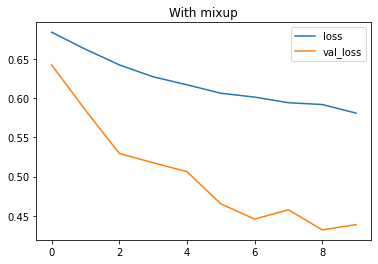

In [ ]:
pd.DataFrame(h1.history)[['loss','val_loss']].plot(title="With mixup")

In [ ]:
print('Build model...')
model2 = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model2.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model2.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model2.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model2.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model2.add(Dense(hidden_dims))
model2.add(Dropout(0.2))
model2.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model2.summary()

Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           250000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 250

In [ ]:
h2 = model2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Epoch 1/10
782/782 [==============================] - 12s 14ms/step - loss: 0.5200 - accuracy: 0.7078 - val_loss: 0.3018 - val_accuracy: 0.8710
Epoch 2/10
782/782 [==============================] - 11s 14ms/step - loss: 0.2268 - accuracy: 0.9109 - val_loss: 0.2629 - val_accuracy: 0.8905
Epoch 3/10
782/782 [==============================] - 11s 14ms/step - loss: 0.1649 - accuracy: 0.9394 - val_loss: 0.2956 - val_accuracy: 0.8870
Epoch 4/10
782/782 [==============================] - 11s 14ms/step - loss: 0.1049 - accuracy: 0.9616 - val_loss: 0.3054 - val_accuracy: 0.8866
Epoch 5/10
782/782 [==============================] - 11s 14ms/step - loss: 0.0733 - accuracy: 0.9750 - val_loss: 0.3578 - val_accuracy: 0.8806
Epoch 6/10
782/782 [==============================] - 11s 14ms/step - loss: 0.0467 - accuracy: 0.9845 - val_loss: 0.4146 - val_accuracy: 0.8819
Epoch 7/10
782/782 [==============================] - 11s 14ms/step - loss: 0.0349 - accuracy: 0.9877 - val_loss: 0.4658 - val_accuracy:

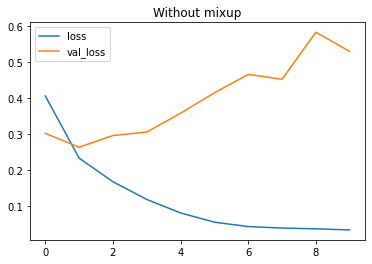

In [ ]:
pd.DataFrame(h2.history)[['loss','val_loss']].plot(title="Without mixup")

# Comparison
See the loss curve with mixup does not overfit.

In [ ]:
## Cite the paper
```
@article{marivate2019improving,
  title={Improving short text classification through global augmentation methods},
  author={Marivate, Vukosi and Sefara, Tshephisho},
  journal={arXiv preprint arXiv:1907.03752},
  year={2019}
}```

https://arxiv.org/abs/1907.03752